In [1]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Exemplo rápido para confirmar que está usando a GPU
x = torch.rand(5, 5).to(device)
y = torch.rand(5, 5).to(device)
z = x @ y
print("Tensor on GPU:", z.is_cuda)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda
Tensor on GPU: True


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import ResNet50_Weights

import pydicom
import numpy as np
import pandas as pd
import os
import glob
from PIL import Image, ImageDraw

from sklearn.metrics import recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, ToPILImage

try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
    from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
except ImportError:
    print("Biblioteca pytorch-grad-cam não encontrada. Instale com: pip install grad-cam")

# --- CUDA Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("Configuração inicial e imports concluídos (PyTorch).")

Using device: cuda
Configuração inicial e imports concluídos (PyTorch).


## Preparação dos Dados

In [ ]:
"""
- PREPARAÇÃO INICIAL DE DADOS E DIVISÃO EM CONJUNTOS DE TREINO/TESTE
"""

# Configuração de caminhos
image_base_dir = 'rsna-pneumonia-detection-challenge/stage_2_train_images'
annotation_file_path = 'rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'
detailed_info_path = 'rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv'

# Carregar Dados
annotations_df = pd.read_csv(annotation_file_path)
detailed_info_df = pd.read_csv(detailed_info_path)

dcm_files = glob.glob(os.path.join(image_base_dir, '*.dcm'))
patient_id_to_path = {os.path.splitext(os.path.basename(dcm_path))[0]: dcm_path for dcm_path in dcm_files}

patient_id_to_annotations = {}
for patient_id, group in annotations_df.groupby('patientId'):
    patient_id_to_annotations[patient_id] = group.to_dict('records')

patient_id_to_detailed_class = detailed_info_df.set_index('patientId')['class'].to_dict()

# Criar o DataFrame images_with_boxes_df
data_for_df = []
available_patient_ids = list(patient_id_to_path.keys())

for patient_id in available_patient_ids:
    patient_annotations = annotations_df[annotations_df['patientId'] == patient_id].to_dict('records')

    if not patient_annotations:
        detailed_class = patient_id_to_detailed_class.get(patient_id, 'Unknown')
        current_target = 0
        if 'Lung Opacity' in detailed_class:
            current_target = 1

        data_for_df.append({
            'patientId': patient_id,
            'image_path': patient_id_to_path.get(patient_id),
            'Target': current_target,
            'detailed_class': detailed_class,
            'boxes': [],
            'num_boxes': 0
        })
        continue

    image_target = patient_annotations[0]['Target']
    image_path = patient_id_to_path.get(patient_id)

    boxes = []
    if image_target == 1:
        for ann in patient_annotations:
            if not pd.isna(ann['x']) and ann['Target'] == 1:
                x, y, w, h = ann['x'], ann['y'], ann['width'], ann['height']
                boxes.append([x, y, x + w, y + h])

    detailed_class = patient_id_to_detailed_class.get(patient_id, 'Unknown')

    final_target = 0
    if 'Lung Opacity' in detailed_class:
        final_target = 1
    elif image_target == 1 and 'Lung Opacity' not in detailed_class:
        print(f"Warning: Patient {patient_id} has Target 1 in annotations but detailed_class is {detailed_class}. Setting Target based on detailed_class.")
        final_target = 0
    else:
        final_target = image_target

    if image_path:
        data_for_df.append({
            'patientId': patient_id,
            'image_path': image_path,
            'Target': final_target,
            'detailed_class': detailed_class,
            'boxes': boxes,
            'num_boxes': len(boxes)
        })

images_with_boxes_df = pd.DataFrame(data_for_df)

# Filtrar imagens sem caminho
images_with_boxes_df.dropna(subset=['image_path'], inplace=True)
images_with_boxes_df.reset_index(drop=True, inplace=True)

print("Dados carregados e DataFrame de imagens criado.")
print(f"Número de imagens no DataFrame: {len(images_with_boxes_df)}")
print(f"Distribuição da classe Target:\n{images_with_boxes_df['Target'].value_counts()}")

# Divisão em Main e Teste Final
if len(images_with_boxes_df) > 0 :
    main_df, test_df_final = train_test_split(
        images_with_boxes_df,
        test_size=0.15,
        random_state=SEED,
        stratify=images_with_boxes_df['Target']
    )
    print(f"\nDataFrame principal para K-Fold: {len(main_df)}")
    print(f"DataFrame de Teste Final Holdout: {len(test_df_final)}")
    print(f"Distribuição do Target no Teste Final:\n{test_df_final['Target'].value_counts(normalize=True)}")
else:
    print("DataFrame images_with_boxes_df está vazio. Verifique o carregamento de dados.")
    main_df = pd.DataFrame()
    test_df_final = pd.DataFrame()

Dados carregados e DataFrame de imagens criado.
Número de imagens no DataFrame: 26684
Distribuição da classe Target:
Target
1    17833
0     8851
Name: count, dtype: int64

DataFrame principal para K-Fold: 22681
DataFrame de Teste Final Holdout: 4003
Distribuição do Target no Teste Final:
Target
1    0.668249
0    0.331751
Name: proportion, dtype: float64


In [ ]:
"""
- DEFINIÇÃO DO DATASET E TRANSFORMAÇÕES NECESSÁRIAS:
"""

class PneumoniaDataset(Dataset):
    # Dataset para carregar imagens DICOM e seus rótulos.
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['Target']

        try:
            dcm_data = pydicom.dcmread(image_path)
            image = dcm_data.pixel_array
        except Exception as e:
            print(f"Error reading DICOM file {image_path}: {e}")
            image = np.zeros((256, 256), dtype=np.uint8)
            label = 0

        if image.dtype != np.uint8:
            image = image.astype(np.float32)
            min_val = image.min()
            max_val = image.max()
            if max_val - min_val > 0:
                image = (image - min_val) / (max_val - min_val) * 255.0
            else:
                image = np.zeros_like(image, dtype=np.float32)
            image = image.astype(np.uint8)

        if image.ndim == 2:
            image = np.stack([image] * 3, axis=-1)

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32).unsqueeze(0)

# Define Image Transformations
IMG_SIZE = 256
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

print("PyTorch Dataset e Transforms definidos.")

PyTorch Dataset e Transforms definidos.


In [ ]:
"""
- BALANCEAMENTO DE CLASSES:

Balanceamento das classes dos DataFrames de treino, validação e teste,
especialmente nas colunas 'Target' e 'detailed_class', para garantir uma distribuição
mais equitativa dos dados.
"""

def balance_dataframe(df_to_balance, random_seed=42):
    # Balanceia um DataFrame com base nas classes 'Target' e 'detailed_class'.
    np.random.seed(random_seed)

    # Identifica amostras "Lung Opacity" (Target == 1)
    df_lung_opacity = df_to_balance[df_to_balance['detailed_class'] == 'Lung Opacity'].copy()
    df_lung_opacity['Target'] = 1
    n_lung_opacity = len(df_lung_opacity)

    if n_lung_opacity == 0:
        print("Warning: Nenhuma amostra 'Lung Opacity' encontrada para balancear.")
        non_lung_opacity_df = df_to_balance[df_to_balance['detailed_class'] != 'Lung Opacity'].copy()
        if not non_lung_opacity_df.empty:
            print("  Retornando amostras não-'Lung Opacity' (não balanceado).")
            non_lung_opacity_df.loc[:, 'Target'] = 0
            return non_lung_opacity_df.reset_index(drop=True)
        return pd.DataFrame(columns=df_to_balance.columns)

    # Identifica as subclasses de Target == 0
    df_target_0_candidates = df_to_balance[df_to_balance['detailed_class'] != 'Lung Opacity'].copy()
    df_target_0_candidates['Target'] = 0

    df_neg_normal = df_target_0_candidates[df_target_0_candidates['detailed_class'] == 'Normal'].copy()
    df_neg_no_lung = df_target_0_candidates[df_target_0_candidates['detailed_class'] == 'No Lung Opacity / Not Normal'].copy()

    # Determina o número de amostras desejado para cada subclasse de Target 0
    target_samples_normal = n_lung_opacity // 2
    target_samples_no_lung = n_lung_opacity - target_samples_normal

    sampled_neg_list = []

    # Amostrar de 'Normal'
    if len(df_neg_normal) > 0:
        if len(df_neg_normal) >= target_samples_normal:
            sampled_neg_list.append(df_neg_normal.sample(n=target_samples_normal, replace=False, random_state=random_seed))
        else:
            print(f"Info: 'Normal' (Target=0) tem menos que o desejado ({target_samples_normal}). Usando todas as {len(df_neg_normal)} disponíveis.")
            sampled_neg_list.append(df_neg_normal.copy())
            target_samples_no_lung = n_lung_opacity - len(df_neg_normal)
            if target_samples_no_lung < 0: target_samples_no_lung = 0
    elif target_samples_normal > 0:
        print(f"Warning: Nenhuma amostra 'Normal' (Target=0) disponível. Toda a cota de Target=0 ({n_lung_opacity}) será tentada com 'No Lung Opacity / Not Normal'.")
        target_samples_no_lung = n_lung_opacity

    # Amostrar de 'No Lung Opacity / Not Normal'
    if len(df_neg_no_lung) > 0:
        if target_samples_no_lung == 0:
            pass
        elif len(df_neg_no_lung) >= target_samples_no_lung:
            sampled_neg_list.append(df_neg_no_lung.sample(n=target_samples_no_lung, replace=False, random_state=random_seed))
        else:
            print(f"Info: 'No Lung Opacity / Not Normal' (Target=0) tem menos que o desejado ({target_samples_no_lung}). Usando todas as {len(df_neg_no_lung)} disponíveis.")
            sampled_neg_list.append(df_neg_no_lung.copy())
    elif target_samples_no_lung > 0 :
        print(f"Warning: Nenhuma amostra 'No Lung Opacity / Not Normal' (Target=0) disponível, mas {target_samples_no_lung} eram desejadas.")

    df_neg_balanced = pd.DataFrame(columns=df_to_balance.columns)
    if sampled_neg_list:
        df_neg_balanced = pd.concat(sampled_neg_list)

    if len(df_neg_balanced) < n_lung_opacity and not df_neg_balanced.empty:
        print(f"Info: Total de amostras Target=0 ({len(df_neg_balanced)}) é menor que Target=1 ({n_lung_opacity}). Realizando oversampling nas amostras Target=0 coletadas.")
        df_neg_balanced = df_neg_balanced.sample(n=n_lung_opacity, replace=True, random_state=random_seed)
    elif df_neg_balanced.empty and n_lung_opacity > 0:
        print("Alerta Extremo: Nenhuma amostra Target=0 ('Normal' ou 'No Lung Opacity / Not Normal') pôde ser selecionada. O conjunto Target=0 estará vazio.")

    # Amostras positivas (Target 1)
    df_pos_balanced = df_lung_opacity.copy()

    # Combinar e embaralhar
    if df_neg_balanced.empty and not df_pos_balanced.empty:
        print("Balanceamento 1:1 não foi possível pois não há amostras Target=0. Retornando apenas Target=1.")
        return df_pos_balanced.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    elif not df_neg_balanced.empty and df_pos_balanced.empty:
        print("Balanceamento 1:1 não foi possível pois não há amostras Target=1 (apesar de n_lung_opacity > 0, estranho). Retornando apenas Target=0.")
        return df_neg_balanced.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    elif df_neg_balanced.empty and df_pos_balanced.empty:
        print("Nenhuma amostra Target=0 ou Target=1 para balancear.")
        return pd.DataFrame(columns=df_to_balance.columns)

    balanced_df = pd.concat([df_neg_balanced, df_pos_balanced]).sample(frac=1, random_state=random_seed).reset_index(drop=True)

    print(f"\nBalanceamento (intended_split) completo. Estatísticas:")
    print(f"  Total de amostras: {len(balanced_df)}")
    print(f"  Distribuição do Target:\n{balanced_df['Target'].value_counts()}")
    if 0 in balanced_df['Target'].unique():
        print(f"  Distribuição da Classe Detalhada para Target=0:\n{balanced_df[balanced_df['Target'] == 0]['detailed_class'].value_counts()}")
    if 1 in balanced_df['Target'].unique():
        print(f"  Distribuição da Classe Detalhada para Target=1:\n{balanced_df[balanced_df['Target'] == 1]['detailed_class'].value_counts(dropna=False)}")

    return balanced_df

## Modelo Resnet50 com Balanceamento e Descongelamento das 10 Camadas: 

In [ ]:
"""
- DEFINIÇÃO DO MODELO RESNET50 PARA CLASSIFICAÇÃO BINÁRIA:

Define uma classe de modelo `ResNet50BinaryClassifier` que utiliza uma ResNet50
pré-treinada. Inicialmente, todos os parâmetros são congelados, mas a função
permite descongelar um número específico das últimas camadas convolucionais
e de Batch Normalization para fine-tuning. A camada final de classificação
é substituída para uma saída binária.
"""

class ResNet50BinaryClassifier(nn.Module):
    # Modelo ResNet50 para classificação binária com opção de descongelamento de camadas.
    def __init__(self, pretrained_weights=ResNet50_Weights.IMAGENET1K_V1, unfreeze_layers=0):
        super(ResNet50BinaryClassifier, self).__init__()
        self.base_model = models.resnet50(weights=pretrained_weights)

        # Congela todos os parâmetros inicialmente
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Descongelar as últimas 'n' camadas Conv2d ou BatchNorm2d
        if unfreeze_layers > 0:
            conv_bn_layers = []
            for module in self.base_model.modules():
                if isinstance(module, (nn.Conv2d, nn.BatchNorm2d)):
                    conv_bn_layers.append(module)

            num_to_unfreeze = min(unfreeze_layers, len(conv_bn_layers))

            if num_to_unfreeze > 0:
                print(f"Descongelando as últimas {num_to_unfreeze} camadas Conv2D/BatchNorm2d...")
                for layer_to_unfreeze in conv_bn_layers[-num_to_unfreeze:]:
                    for param in layer_to_unfreeze.parameters():
                        param.requires_grad = True
            else:
                print("Nenhuma camada Conv2D/BatchNorm2d para descongelar com o critério fornecido.")

        # Substitui a camada final (sempre treinável)
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_ftrs, 1)

    def forward(self, x):
        return self.base_model(x)

print("Classe ResNet50BinaryClassifier com descongelamento granular definida.")

Classe ResNet50BinaryClassifier com descongelamento granular definida.


In [ ]:
"""
- TREINAMENTO DO MODELO COM K-FOLD CROSS-VALIDATION ESTRATIFICADO:

Implementa um loop de treinamento K-Fold cross-validation para o modelo.
Para cada fold, balanceia os dados de treino, configura DataLoaders,
inicializa o modelo e o otimizador, e executa o treinamento e validação
por um número de épocas. Monitora e salva o melhor modelo com base no
recall de validação, registrando os resultados de cada fold.
"""

# K-Fold Cross-Validation e Loop de Treinamento
N_FOLDS = 5
EPOCHS_FEATURE_EXTRACTION = 5
EPOCHS_FINETUNING = 5
BATCH_SIZE = 32
LEARNING_RATE_FT = 0.001
LEARNING_RATE_FINETUNE = 1e-5

# Controle de Logging
LOG_INTERVAL_BATCHES = 50

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

if 'main_df' not in locals() or main_df.empty:
    print("Erro: DataFrame 'main_df' não encontrado ou está vazio. Execute a célula de carregamento de dados (Célula 2).")
else:
    X = main_df.index
    y = main_df['Target'].values

fold_results = []
best_overall_val_recall = -1.0
best_overall_model_path = ""

current_model_type_description = "ResNet50 (Fine-tune Last 10) com Balanceamento"
UNFREEZE_COUNT = 10
USE_BALANCING = True

print(f"\n--- Iniciando Treinamento: {current_model_type_description} ---")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n===== Fold {fold+1}/{N_FOLDS} =====")

    train_fold_df_original = main_df.iloc[train_idx]
    val_fold_df = main_df.iloc[val_idx]

    if USE_BALANCING:
        print("Balanceando dados de treino do fold...")
        train_fold_df_for_loader = balance_dataframe(train_fold_df_original, random_seed=SEED)
    else:
        print("Usando dados de treino do fold sem balanceamento.")
        train_fold_df_for_loader = train_fold_df_original.copy()

    print(f"Tamanho do treino (fold {fold+1}): {len(train_fold_df_for_loader)}")
    print(f"Distribuição do Target no treino (fold {fold+1}):\n{train_fold_df_for_loader['Target'].value_counts(normalize=True)}")
    print(f"Tamanho da validação (fold {fold+1}): {len(val_fold_df)}")
    print(f"Distribuição do Target na validação (fold {fold+1}):\n{val_fold_df['Target'].value_counts(normalize=True)}")

    train_dataset_fold = PneumoniaDataset(train_fold_df_for_loader, transform=data_transforms['train'])
    val_dataset_fold = PneumoniaDataset(val_fold_df, transform=data_transforms['val'])

    train_loader_fold = DataLoader(train_dataset_fold, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True if device.type == 'cuda' else False)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True if device.type == 'cuda' else False)

    model = ResNet50BinaryClassifier(unfreeze_layers=UNFREEZE_COUNT).to(device)

    current_lr = LEARNING_RATE_FINETUNE if UNFREEZE_COUNT > 0 else LEARNING_RATE_FT
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=current_lr)
    criterion = nn.BCEWithLogitsLoss()

    best_fold_val_recall = -1.0
    model_type_slug = current_model_type_description.lower().replace(" ", "_").replace("(", "").replace(")", "")
    best_fold_model_path = f'best_model_fold_{fold+1}_{model_type_slug}.pth'

    num_epochs_current_phase = EPOCHS_FINETUNING if UNFREEZE_COUNT > 0 else EPOCHS_FEATURE_EXTRACTION

    for epoch in range(num_epochs_current_phase):
        print(f"\n--- Epoch {epoch+1}/{num_epochs_current_phase} ---")
        # Fase de Treinamento
        model.train()
        running_loss_train = 0.0
        train_preds_epoch = []
        train_labels_epoch = []

        num_batches_train = len(train_loader_fold)

        for batch_idx, (inputs, labels) in enumerate(train_loader_fold):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss_train += loss.item() * inputs.size(0)

            train_preds_epoch.extend(torch.sigmoid(outputs).detach().cpu().numpy())
            train_labels_epoch.extend(labels.detach().cpu().numpy())

            if (batch_idx + 1) % LOG_INTERVAL_BATCHES == 0 or (batch_idx + 1) == num_batches_train:
                print(f"  Fold {fold+1}, Epoch {epoch+1}: Batch {batch_idx+1}/{num_batches_train} - Training Loss (current batch): {loss.item():.4f}")

        epoch_loss_train = running_loss_train / len(train_loader_fold.dataset)
        epoch_acc_train = accuracy_score(np.array(train_labels_epoch).round(), (np.array(train_preds_epoch) > 0.5).astype(int))
        epoch_auc_train = roc_auc_score(train_labels_epoch, train_preds_epoch)

        # Fase de Validação
        model.eval()
        running_loss_val = 0.0
        val_preds_epoch = []
        val_labels_epoch = []
        num_batches_val = len(val_loader_fold)
        with torch.no_grad():
            for batch_idx_val, (inputs, labels) in enumerate(val_loader_fold):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item() * inputs.size(0)
                val_preds_epoch.extend(torch.sigmoid(outputs).cpu().numpy())
                val_labels_epoch.extend(labels.cpu().numpy())

        epoch_loss_val = running_loss_val / len(val_loader_fold.dataset)
        val_labels_epoch_arr = np.array(val_labels_epoch)
        val_preds_epoch_arr = np.array(val_preds_epoch)

        val_preds_binary = (val_preds_epoch_arr > 0.5).astype(int)

        if len(np.unique(val_labels_epoch_arr)) > 1:
            epoch_auc_val = roc_auc_score(val_labels_epoch_arr, val_preds_epoch_arr)
            epoch_recall_val = recall_score(val_labels_epoch_arr, val_preds_binary)
        else:
            epoch_auc_val = 0.5
            epoch_recall_val = 0.0
            print(f"Warning: Only one class present in validation labels for Fold {fold+1}, Epoch {epoch+1}. AUC set to 0.5, Recall set to 0.0.")

        epoch_acc_val = accuracy_score(val_labels_epoch_arr.round(), (val_preds_epoch_arr > 0.5).astype(int))

        print(f"Epoch {epoch+1}/{num_epochs_current_phase} Results | "
              f"Train Loss: {epoch_loss_train:.4f} Acc: {epoch_acc_train:.4f} AUC: {epoch_auc_train:.4f} | "
              f"Val Loss: {epoch_loss_val:.4f} Acc: {epoch_acc_val:.4f} Recall: {epoch_recall_val:.4f} AUC: {epoch_auc_val:.4f}")

        if epoch_recall_val > best_fold_val_recall:
            best_fold_val_recall = epoch_recall_val
            torch.save(model.state_dict(), best_fold_model_path)
            print(f"  Validation Recall melhorou para {best_fold_val_recall:.4f}. Saved model for fold {fold+1} to {best_fold_model_path}")

            if best_fold_val_recall > best_overall_val_recall:
                best_overall_val_recall = best_fold_val_recall
                best_overall_model_path = best_fold_model_path
                print(f"  *** New best overall model found with Val Recall: {best_overall_val_recall:.4f} from fold {fold+1} ***")

    fold_results.append({'fold': fold+1, 'val_recall': best_fold_val_recall, 'model_path': best_fold_model_path})
    print(f"Best Validation Recall for Fold {fold+1}: {best_fold_val_recall:.4f}")

print("\n--- K-Fold Cross-Validation Summary ---")
for res in fold_results:
    print(f"Fold {res['fold']}: Best Validation Recall = {res['val_recall']:.4f}, Model: {res['model_path']}")

if fold_results:
    avg_val_recall = np.mean([res['val_recall'] for res in fold_results])
    print(f"\nAverage Best Validation Recall across {N_FOLDS} folds: {avg_val_recall:.4f}")
    print(f"Path to the overall best model (based on Val Recall): {best_overall_model_path}")
else:
    print("\nNenhum fold foi completado. Verifique a configuração.")


--- Iniciando Treinamento: ResNet50 (Fine-tune Last 10) com Balanceamento ---

===== Fold 1/5 =====
Balanceando dados de treino do fold...

Balanceamento (intended_split) completo. Estatísticas:
  Total de amostras: 8134
  Distribuição do Target:
Target
1    4067
0    4067
Name: count, dtype: int64
  Distribuição da Classe Detalhada para Target=0:
detailed_class
No Lung Opacity / Not Normal    2034
Normal                          2033
Name: count, dtype: int64
  Distribuição da Classe Detalhada para Target=1:
detailed_class
Lung Opacity    4067
Name: count, dtype: int64
Tamanho do treino (fold 1): 8134
Distribuição do Target no treino (fold 1):
Target
1    0.5
0    0.5
Name: proportion, dtype: float64
Tamanho da validação (fold 1): 4537
Distribuição do Target na validação (fold 1):
Target
1    0.668283
0    0.331717
Name: proportion, dtype: float64
Descongelando as últimas 10 camadas Conv2D/BatchNorm2d...

--- Epoch 1/5 ---
   Fold 1, Epoch 1: Batch 50/255 - Training Loss (current bat

In [ ]:
"""
- SUMÁRIO DO MODELO
"""

from torchinfo import summary

model = ResNet50BinaryClassifier(unfreeze_layers=10).to(device)
batch_size = 32
input_size = (batch_size, 3, 256, 256)

summary(model, input_size=input_size)

Descongelando as últimas 10 camadas Conv2D/BatchNorm2d...


Layer (type:depth-idx)                        Output Shape              Param #
ResNet50BinaryClassifier                      [32, 1]                   --
├─ResNet: 1-1                                 [32, 1]                   --
│    └─Conv2d: 2-1                            [32, 64, 128, 128]        (9,408)
│    └─BatchNorm2d: 2-2                       [32, 64, 128, 128]        (128)
│    └─ReLU: 2-3                              [32, 64, 128, 128]        --
│    └─MaxPool2d: 2-4                         [32, 64, 64, 64]          --
│    └─Sequential: 2-5                        [32, 256, 64, 64]         --
│    │    └─Bottleneck: 3-1                   [32, 256, 64, 64]         (75,008)
│    │    └─Bottleneck: 3-2                   [32, 256, 64, 64]         (70,400)
│    │    └─Bottleneck: 3-3                   [32, 256, 64, 64]         (70,400)
│    └─Sequential: 2-6                        [32, 512, 32, 32]         --
│    │    └─Bottleneck: 3-4                   [32, 512, 32, 32]      

In [ ]:
"""
- TREINAMENTO DOS MODELOS DE CADA FOLD K-Fold
"""

print("\n--- Avaliando os Melhores Modelos de Cada Fold no Conjunto de Teste Final Holdout ---")

final_test_results_per_fold = []

if not fold_results:
    print("Nenhum resultado de fold encontrado. Execute o loop de treinamento K-Fold primeiro.")
else:
    if 'test_df_final' not in locals() or test_df_final.empty:
        print("Erro: DataFrame 'test_df_final' não encontrado ou vazio. Não é possível avaliar.")
    else:
        test_final_dataset = PneumoniaDataset(test_df_final, transform=data_transforms['val'])
        test_final_loader = DataLoader(test_final_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True if device.type == 'cuda' else False)

        num_test_samples = len(test_final_loader.dataset)

        for fold_res in fold_results:
            fold_num = fold_res['fold']
            model_path_for_fold = fold_res['model_path']

            print(f"\n--- Avaliando Modelo do Fold {fold_num} ({model_path_for_fold}) no Teste Final ---")

            if "base_frozen" in model_path_for_fold:
                loaded_model_unfreeze_count = 0
            elif "last_5" in model_path_for_fold:
                loaded_model_unfreeze_count = 5
            elif "last_10" in model_path_for_fold:
                loaded_model_unfreeze_count = 10
            else:
                print(f"Não foi possível determinar UNFREEZE_COUNT a partir de {model_path_for_fold}. Assumindo o UNFREEZE_COUNT da última execução de treinamento ({UNFREEZE_COUNT}).")
                loaded_model_unfreeze_count = UNFREEZE_COUNT

            current_fold_model = ResNet50BinaryClassifier(unfreeze_layers=loaded_model_unfreeze_count).to(device)
            current_fold_model.load_state_dict(torch.load(model_path_for_fold, map_location=device))
            current_fold_model.eval()
            print(f"Modelo do Fold {fold_num} carregado com {loaded_model_unfreeze_count} camadas descongeladas (estimado).")

            test_preds_fold = []
            test_labels_fold = []
            running_loss_test_fold = 0.0
            criterion_test = nn.BCEWithLogitsLoss()

            processed_samples = 0
            with torch.no_grad():
                for batch_idx, (inputs, labels) in enumerate(test_final_loader):
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = current_fold_model(inputs)
                    loss = criterion_test(outputs, labels)
                    running_loss_test_fold += loss.item() * inputs.size(0)
                    test_preds_fold.extend(torch.sigmoid(outputs).cpu().numpy())
                    test_labels_fold.extend(labels.cpu().numpy())

                    processed_samples += inputs.size(0)
                    print(f"  Avaliando Fold {fold_num}: {processed_samples}/{num_test_samples} amostras processadas...", end='\r')

            print(f"\nAvaliação do Fold {fold_num} completa.")

            test_loss_fold = running_loss_test_fold / num_test_samples
            test_labels_fold_arr = np.array(test_labels_fold)
            test_preds_fold_arr = np.array(test_preds_fold)

            test_preds_binary_fold = (test_preds_fold_arr > 0.5).astype(int)

            if len(np.unique(test_labels_fold_arr)) > 1:
                test_auc_fold = roc_auc_score(test_labels_fold_arr, test_preds_fold_arr)
                test_acc_fold = accuracy_score(test_labels_fold_arr, test_preds_binary_fold)
                test_recall_fold = recall_score(test_labels_fold_arr, test_preds_binary_fold)
                test_f1_fold = f1_score(test_labels_fold_arr, test_preds_binary_fold)
            else:
                test_auc_fold = 0.5
                test_acc_fold = accuracy_score(test_labels_fold_arr, test_preds_binary_fold)
                test_recall_fold = 0.0 if np.all(test_labels_fold_arr == 1) else (1.0 if np.all(test_labels_fold_arr == 0) else 0.0)
                test_f1_fold = 0.0
                print(f"Warning: Only one class present in final test set labels for Fold {fold_num}. AUC and F1-score might be misleading, Recall adjusted.")

            print(f"Resultados do Fold {fold_num} no Teste Final Holdout:")
            print(f"  Loss: {test_loss_fold:.4f}")
            print(f"  Accuracy: {test_acc_fold:.4f}")
            print(f"  Recall: {test_recall_fold:.4f}")
            print(f"  F1-Score: {test_f1_fold:.4f}")
            print(f"  AUC: {test_auc_fold:.4f}")

            final_test_results_per_fold.append({
                'fold': fold_num,
                'loss': test_loss_fold,
                'accuracy': test_acc_fold,
                'recall': test_recall_fold,
                'f1_score': test_f1_fold,
                'auc': test_auc_fold
            })

# Resumo das Métricas no Teste Final
if final_test_results_per_fold:
    print("\n--- Resumo Agregado das Métricas no Conjunto de Teste Final (Todos os Folds) ---")

    losses = [res['loss'] for res in final_test_results_per_fold]
    accuracies = [res['accuracy'] for res in final_test_results_per_fold]
    recalls = [res['recall'] for res in final_test_results_per_fold]
    f1_scores = [res['f1_score'] for res in final_test_results_per_fold]
    aucs = [res['auc'] for res in final_test_results_per_fold]

    metrics_to_summarize = {
        'Loss': losses,
        'Accuracy': accuracies,
        'Recall': recalls,
        'F1-Score': f1_scores,
        'AUC': aucs
    }

    for metric_name, values in metrics_to_summarize.items():
        min_val = np.min(values)
        max_val = np.max(values)
        mean_val = np.mean(values)
        std_val = np.std(values)

        print(f"\n{metric_name}:")
        print(f"  Mínimo: {min_val:.4f}")
        print(f"  Máximo: {max_val:.4f}")
        print(f"  Média: {mean_val:.4f}")
        print(f"  Desvio Padrão: {std_val:.4f}")
else:
    print("\nNenhum resultado de avaliação de fold no conjunto de teste final. Verifique a execução.")


--- Avaliando os Melhores Modelos de Cada Fold no Conjunto de Teste Final Holdout ---

--- Avaliando Modelo do Fold 1 (best_model_fold_1_resnet50_fine-tune_last_10_com_balanceamento.pth) no Teste Final ---
Descongelando as últimas 10 camadas Conv2D/BatchNorm2d...
Modelo do Fold 1 carregado com 10 camadas descongeladas (estimado).
  Avaliando Fold 1: 4003/4003 amostras processadas...
Avaliação do Fold 1 completa.
Resultados do Fold 1 no Teste Final Holdout:
  Loss: 0.6091
  Accuracy: 0.7165
  Recall: 0.5974
  F1-Score: 0.7379
  AUC: 0.8953

--- Avaliando Modelo do Fold 2 (best_model_fold_2_resnet50_fine-tune_last_10_com_balanceamento.pth) no Teste Final ---
Descongelando as últimas 10 camadas Conv2D/BatchNorm2d...
Modelo do Fold 2 carregado com 10 camadas descongeladas (estimado).
  Avaliando Fold 2: 4003/4003 amostras processadas...
Avaliação do Fold 2 completa.
Resultados do Fold 2 no Teste Final Holdout:
  Loss: 0.6053
  Accuracy: 0.7287
  Recall: 0.6247
  F1-Score: 0.7547
  AUC: 0.

In [ ]:
"""
- AVALIAÇÃO DO MELHOR MODELO NO CONJUNTO DE TESTE
"""

print(f"\n--- Avaliando o Melhor Modelo Geral ({best_overall_model_path}) no Conjunto de Teste Final Holdout ---")

if not best_overall_model_path:
    print("Nenhum modelo foi treinado ou salvo. Execute o loop de treinamento K-Fold primeiro.")
else:
    # Heurística para determinar UNFREEZE_COUNT
    if "base_frozen" in best_overall_model_path:
        loaded_model_unfreeze_count = 0
    elif "last_5" in best_overall_model_path:
        loaded_model_unfreeze_count = 5
    elif "last_10" in best_overall_model_path:
        loaded_model_unfreeze_count = 10
    else:
        print(f"Não foi possível determinar UNFREEZE_COUNT a partir de {best_overall_model_path}. Assumindo o UNFREEZE_COUNT da última execução de treinamento ({UNFREEZE_COUNT}).")
        loaded_model_unfreeze_count = UNFREEZE_COUNT

    final_model = ResNet50BinaryClassifier(unfreeze_layers=loaded_model_unfreeze_count).to(device)
    final_model.load_state_dict(torch.load(best_overall_model_path, map_location=device))
    final_model.eval()
    print(f"Modelo {best_overall_model_path} carregado com {loaded_model_unfreeze_count} camadas descongeladas (estimado).")

    # Cria DataLoader para o conjunto de teste final (test_df_final)
    if 'test_df_final' not in locals() or test_df_final.empty:
        print("Erro: DataFrame 'test_df_final' não encontrado ou vazio. Não é possível avaliar.")
    else:
        test_final_dataset = PneumoniaDataset(test_df_final, transform=data_transforms['val'])
        test_final_loader = DataLoader(test_final_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True if device.type == 'cuda' else False)

        test_preds_final = []
        test_labels_final = []
        running_loss_test_final = 0.0
        criterion_test = nn.BCEWithLogitsLoss()

        num_test_samples = len(test_final_loader.dataset)
        processed_samples = 0

        print(f"Iniciando avaliação em {num_test_samples} amostras de teste...")
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(test_final_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = final_model(inputs)
                loss = criterion_test(outputs, labels)
                running_loss_test_final += loss.item() * inputs.size(0)
                test_preds_final.extend(torch.sigmoid(outputs).cpu().numpy())
                test_labels_final.extend(labels.cpu().numpy())

                processed_samples += inputs.size(0)
                print(f"  Avaliando: {processed_samples}/{num_test_samples} amostras processadas...", end='\r')

        print("\nAvaliação completa.")

        test_loss_final = running_loss_test_final / num_test_samples
        test_labels_final_arr = np.array(test_labels_final)
        test_preds_final_arr = np.array(test_preds_final)

        if len(np.unique(test_labels_final_arr)) > 1:
            test_auc_final = roc_auc_score(test_labels_final_arr, test_preds_final_arr)
        else:
            test_auc_final = 0.5
            print("Warning: Only one class in final test set labels. AUC is 0.5.")

        test_acc_final = accuracy_score(test_labels_final_arr.round(), (test_preds_final_arr > 0.5).astype(int))

        print(f"Resultados no Teste Final Holdout:")
        print(f"  Loss: {test_loss_final:.4f}")
        print(f"  Accuracy: {test_acc_final:.4f}")
        print(f"  AUC: {test_auc_final:.4f}")


--- Gerando Matriz de Confusão para o Melhor Modelo (best_model_fold_3_resnet50_fine-tune_last_10_com_balanceamento.pth) no Teste Final Holdout ---

--- Matriz de Confusão (Contagens Absolutas) - Teste Final Holdout ---
                        Predito Não Pneumonia (0)  Predito Pneumonia (1)
Real Não Pneumonia (0)                       1259                     69
Real Pneumonia (1)                           1029                   1646


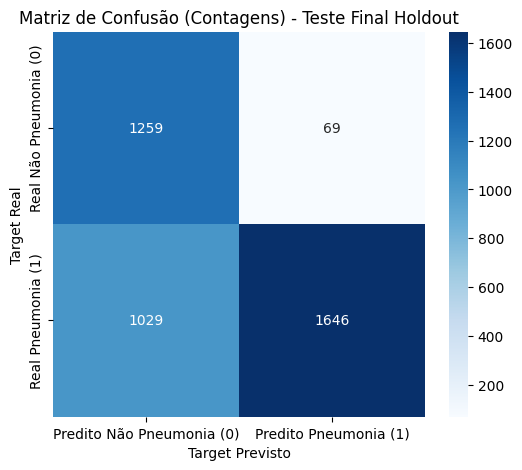

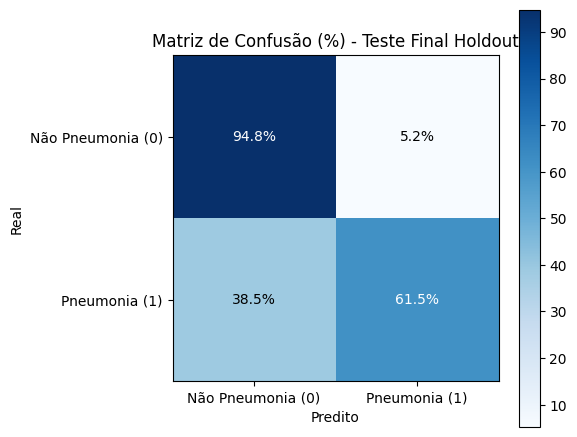


Análise da Matriz de Confusão em % (Teste Final Holdout):
Cada célula mostra a **porcentagem** de amostras da classe real (linha) que foi predita como a classe correspondente (coluna).
A soma das porcentagens em cada linha (horizontalmente) deve ser **100%**.


In [ ]:
"""
- GERAÇÃO DE MATRIZES DE CONFUSÃO PARA O TESTE FINAL:

Calcula e visualiza as matrizes de confusão (em contagens absolutas e porcentagens)
para o melhor modelo treinado, usando o conjunto de teste final.
"""

print(f"\n--- Gerando Matriz de Confusão para o Melhor Modelo ({best_overall_model_path}) no Teste Final Holdout ---")

if not best_overall_model_path:
    print("Nenhum modelo foi treinado ou salvo. Execute o loop de treinamento K-Fold primeiro.")
else:
    y_true_binary_test_final = test_labels_final_arr.flatten().round().astype(int)
    y_pred_binary_test_final = (test_preds_final_arr.flatten() > 0.5).astype(int)

    # Matriz de Confusão (Target Binário Real vs. Previsto Binário) em Contagens
    cm_binary_abs_test = confusion_matrix(
        y_true_binary_test_final,
        y_pred_binary_test_final,
        labels=[0, 1]
    )
    cm_binary_df_test = pd.DataFrame(cm_binary_abs_test,
                                     index=['Real Não Pneumonia (0)', 'Real Pneumonia (1)'],
                                     columns=['Predito Não Pneumonia (0)', 'Predito Pneumonia (1)'])
    print("\n--- Matriz de Confusão (Contagens Absolutas) - Teste Final Holdout ---")
    print(cm_binary_df_test)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_binary_df_test, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusão (Contagens) - Teste Final Holdout')
    plt.xlabel('Target Previsto')
    plt.ylabel('Target Real')
    plt.show()

    # Matriz de Confusão (Target Binário Real vs. Previsto Binário) em %
    if np.sum(cm_binary_abs_test, axis=1).all() > 0:
        cm_binary_percent_test = cm_binary_abs_test.astype('float') / cm_binary_abs_test.sum(axis=1)[:, np.newaxis] * 100

        disp_percent = ConfusionMatrixDisplay(
            confusion_matrix=cm_binary_percent_test,
            display_labels=['Não Pneumonia (0)', 'Pneumonia (1)']
        )
        fig_pct, ax_pct = plt.subplots(figsize=(6,5))

        disp_percent.plot(cmap=plt.cm.Blues, ax=ax_pct, include_values=False)

        for i in range(cm_binary_percent_test.shape[0]):
            for j in range(cm_binary_percent_test.shape[1]):
                ax_pct.text(j, i, f"{cm_binary_percent_test[i, j]:.1f}%",
                            ha="center", va="center",
                            color="white" if cm_binary_percent_test[i, j] > 50 else "black")

        ax_pct.set_title('Matriz de Confusão (%) - Teste Final Holdout')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.tight_layout()
        plt.show()
    else:
        print("Não foi possível calcular a matriz de confusão em porcentagem devido a classes vazias no conjunto de teste final.")

Carregando o melhor modelo de: best_model_fold_3_resnet50_fine-tune_last_10_com_balanceamento.pth
Não foi possível determinar UNFREEZE_COUNT de best_model_fold_3_resnet50_fine-tune_last_10_com_balanceamento.pth. Assumindo 10 (da última execução de treino).
Descongelando as últimas 10 camadas Conv2D/BatchNorm2d...
Modelo carregado para Grad-CAM (com 10 camadas descongeladas).

Gerando Grad-CAM para: 31a00524-b6eb-4d94-99ed-e70827499507.dcm
Target Real: 1 (Lung Opacity)
Bounding Boxes Originais: [[231.0, 417.0, 353.0, 651.0], [569.0, 427.0, 767.0, 647.0]]
Camadas alvo Grad-CAM: ['Conv2d']
Modelo predisse: Classe 0, Prob (classe 1): 0.4541


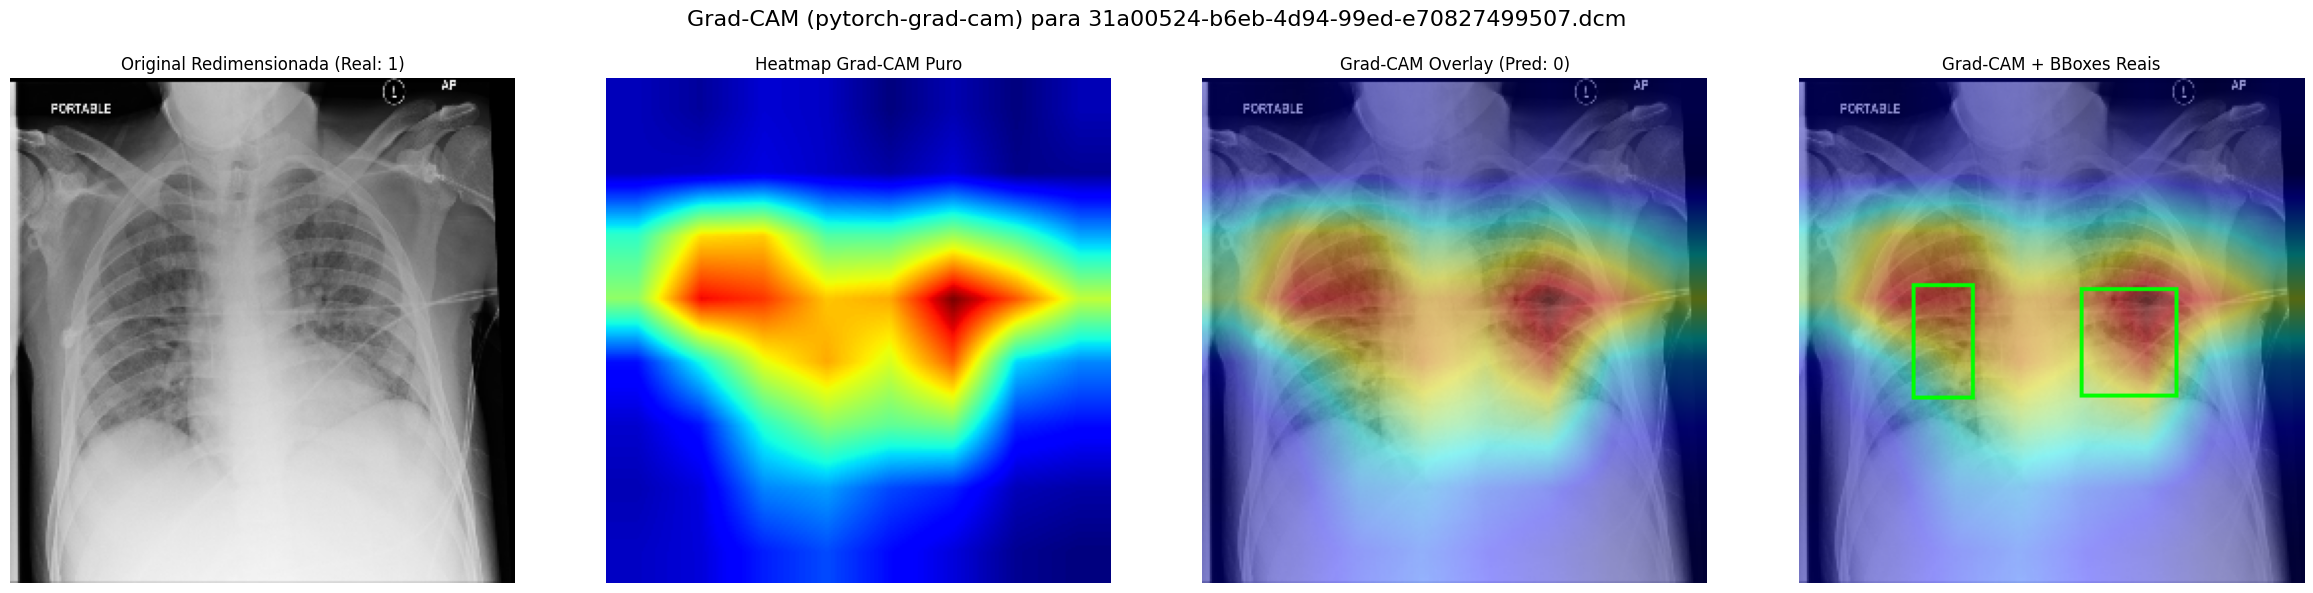

In [ ]:
"""
- GERAÇÃO E VISUALIZAÇÃO DE GRAD-CAM
"""

def generate_grad_cam_with_library(model,
                                   input_tensor_for_model,
                                   original_image_np_0_1_rgb_resized,
                                   target_layers_list,
                                   use_positive_class_target: bool):
    # Gera o heatmap Grad-CAM usando a biblioteca pytorch-grad-cam.
    targets_for_cam = [BinaryClassifierOutputTarget(use_positive_class_target)]

    visualization_result = None
    grayscale_cam_image_for_plot = None

    try:
        with GradCAM(model=model, target_layers=target_layers_list) as cam:
            grayscale_cam_array = cam(input_tensor=input_tensor_for_model, targets=targets_for_cam)

            if grayscale_cam_array is not None and grayscale_cam_array.ndim > 0 and grayscale_cam_array.shape[0] == 1:
                grayscale_cam_image_for_plot = grayscale_cam_array[0, :]
                visualization_result = show_cam_on_image(original_image_np_0_1_rgb_resized,
                                                         grayscale_cam_image_for_plot,
                                                         use_rgb=True,
                                                         image_weight=0.6)
            elif grayscale_cam_array is not None:
                print(f"Warning: grayscale_cam_array shape inesperada: {grayscale_cam_array.shape}.")
                if isinstance(grayscale_cam_array, (list, np.ndarray)) and len(grayscale_cam_array) > 0:
                    grayscale_cam_image_for_plot = grayscale_cam_array[0]
                    if grayscale_cam_image_for_plot.ndim == 3 and grayscale_cam_image_for_plot.shape[0] ==1:
                        grayscale_cam_image_for_plot = grayscale_cam_image_for_plot.squeeze(0)

                    if grayscale_cam_image_for_plot.ndim == 2:
                        visualization_result = show_cam_on_image(original_image_np_0_1_rgb_resized,
                                                                 grayscale_cam_image_for_plot,
                                                                 use_rgb=True,
                                                                 image_weight=0.6)
                    else:
                        print(f"  Forma do heatmap processado não é 2D: {grayscale_cam_image_for_plot.shape}")
            else:
                print("Erro: cam() retornou None para grayscale_cam_array.")

    except AttributeError as ae:
        print(f"AttributeError dentro do GradCAM (provavelmente gradientes são None): {ae}")
        print("Verifique a 'target_layers_list' e a definição dos targets. Para ResNet, tente [model.base_model.layer4[-1].conv3].")
        print("Se o modelo base estiver totalmente congelado (UNFREEZE_COUNT=0), os gradientes podem não fluir para camadas convolucionais da base.")
    except Exception as e_cam:
        print(f"Uma exceção ocorreu ao gerar o Grad-CAM com a biblioteca: {e_cam}")
        import traceback
        traceback.print_exc()

    return visualization_result, grayscale_cam_image_for_plot

# Bloco Principal da Célula Grad-CAM
variables_exist = True
required_vars = ['best_overall_model_path', 'ResNet50BinaryClassifier',
                 'test_df_final', 'data_transforms', 'IMG_SIZE', 'device', 'UNFREEZE_COUNT']
for var_name in required_vars:
    if var_name not in locals() and var_name not in globals():
        print(f"Erro: Variável essencial '{var_name}' não está definida. Execute as células anteriores.")
        variables_exist = False

if variables_exist and (not best_overall_model_path):
    print("Caminho do melhor modelo ('best_overall_model_path') está vazio. Execute o treinamento K-Fold primeiro.")
    variables_exist = False
if variables_exist and ('test_df_final' in locals() and test_df_final.empty):
    print("DataFrame 'test_df_final' está vazio.")
    variables_exist = False

if variables_exist:
    print(f"Carregando o melhor modelo de: {best_overall_model_path}")

    loaded_model_unfreeze_count = UNFREEZE_COUNT
    if "unfreeze0" in best_overall_model_path or "base_frozen" in best_overall_model_path:
        loaded_model_unfreeze_count = 0
    elif "unfreeze5" in best_overall_model_path:
        loaded_model_unfreeze_count = 5
    elif "unfreeze10" in best_overall_model_path:
        loaded_model_unfreeze_count = 10
    else:
        print(f"Não foi possível determinar UNFREEZE_COUNT de {best_overall_model_path}. Assumindo {UNFREEZE_COUNT} (da última execução de treino).")

    grad_cam_model = ResNet50BinaryClassifier(unfreeze_layers=loaded_model_unfreeze_count).to(device)

    try:
        grad_cam_model.load_state_dict(torch.load(best_overall_model_path, map_location=device))
        grad_cam_model.eval()
        print(f"Modelo carregado para Grad-CAM (com {loaded_model_unfreeze_count} camadas descongeladas).")

        if loaded_model_unfreeze_count == 0:
            print("\nALERTA: O modelo carregado parece ter a base ResNet50 totalmente congelada.")
            print("O Grad-CAM em camadas convolucionais congeladas pode não produzir gradientes significativos.")
            print("Para Grad-CAM em camadas da base, idealmente essas camadas deveriam ter requires_grad=True.\n")

        sample_idx = np.random.randint(0, len(test_df_final))
        sample_data = test_df_final.iloc[sample_idx]

        image_path = sample_data['image_path']
        true_label = sample_data['Target']
        detailed_class_true = sample_data['detailed_class']
        true_boxes_original_coords = sample_data['boxes']

        print(f"\nGerando Grad-CAM para: {os.path.basename(image_path)}")
        print(f"Target Real: {true_label} ({detailed_class_true})")
        if true_label == 1 and true_boxes_original_coords and isinstance(true_boxes_original_coords, list) and len(true_boxes_original_coords) > 0:
            print(f"Bounding Boxes Originais: {true_boxes_original_coords}")

        dcm_original = pydicom.dcmread(image_path)
        img_orig_np_dicom = dcm_original.pixel_array
        original_dicom_h, original_dicom_w = img_orig_np_dicom.shape[0], img_orig_np_dicom.shape[1]

        img_orig_np_float = img_orig_np_dicom.astype(np.float32)
        min_val, max_val = img_orig_np_float.min(), img_orig_np_float.max()
        img_orig_np_0_1 = (img_orig_np_float - min_val) / (max_val - min_val) if max_val - min_val > 0 else np.zeros_like(img_orig_np_float)

        if img_orig_np_0_1.ndim == 2:
            img_for_cam_visualization = np.stack([img_orig_np_0_1] * 3, axis=-1)
        elif img_orig_np_0_1.ndim == 3 and img_orig_np_0_1.shape[-1] == 1:
            img_for_cam_visualization = np.concatenate([img_orig_np_0_1] * 3, axis=-1)
        else:
            img_for_cam_visualization = img_orig_np_0_1
        img_for_cam_visualization_resized = cv2.resize(img_for_cam_visualization, (IMG_SIZE, IMG_SIZE))

        img_uint8_for_pil = (img_orig_np_0_1 * 255).astype(np.uint8)
        img_for_model_pil = Image.fromarray(img_uint8_for_pil).convert('RGB')
        input_tensor_vis = data_transforms['val'](img_for_model_pil).unsqueeze(0).to(device)

        try:
            target_layers_for_grad_cam_lib = [grad_cam_model.base_model.layer4[-1].conv3]
            _ = grad_cam_model.base_model.layer4[-1].conv3
        except AttributeError:
            print("Não foi possível acessar model.base_model.layer4[-1].conv3. Tentando model.base_model.layer4[-1].")
            try:
                target_layers_for_grad_cam_lib = [grad_cam_model.base_model.layer4[-1]]
                _ = grad_cam_model.base_model.layer4[-1]
            except AttributeError:
                print("Não foi possível acessar model.base_model.layer4[-1]. Tentando model.base_model.layer4.")
                target_layers_for_grad_cam_lib = [grad_cam_model.base_model.layer4]

        print(f"Camadas alvo Grad-CAM: {[layer.__class__.__name__ for layer in target_layers_for_grad_cam_lib]}")

        with torch.no_grad():
            output_logits = grad_cam_model(input_tensor_vis)
            output_probs = torch.sigmoid(output_logits)
            predicted_class_val = (output_probs > 0.5).item()
            predicted_prob_val = output_probs.item()
        print(f"Modelo predisse: Classe {int(predicted_class_val)}, Prob (classe 1): {predicted_prob_val:.4f}")

        target_positive_class_for_cam = bool(predicted_class_val == 1)

        visualization, grayscale_heatmap_plot = generate_grad_cam_with_library(
            grad_cam_model, input_tensor_vis, img_for_cam_visualization_resized,
            target_layers_for_grad_cam_lib, target_positive_class_for_cam
        )

        if visualization is not None:
            fig, axs = plt.subplots(1, 4, figsize=(24, 6))

            axs[0].imshow(img_for_cam_visualization_resized)
            axs[0].set_title(f"Original Redimensionada (Real: {true_label})")
            axs[0].axis('off')

            if grayscale_heatmap_plot is not None:
                axs[1].imshow(grayscale_heatmap_plot, cmap='jet')
                axs[1].set_title("Heatmap Grad-CAM Puro")
            else:
                axs[1].set_title("Heatmap Puro N/A")
            axs[1].axis('off')

            axs[2].imshow(visualization)
            axs[2].set_title(f"Grad-CAM Overlay (Pred: {int(predicted_class_val)})")
            axs[2].axis('off')

            img_overlay_with_boxes = visualization.copy()
            title_bbox = f"Grad-CAM Overlay (Pred: {int(predicted_class_val)})"
            if true_label == 1 and true_boxes_original_coords and isinstance(true_boxes_original_coords, list) and len(true_boxes_original_coords) > 0:
                scale_x = IMG_SIZE / original_dicom_w
                scale_y = IMG_SIZE / original_dicom_h

                pil_img_overlay_with_boxes = Image.fromarray(img_overlay_with_boxes)
                draw = ImageDraw.Draw(pil_img_overlay_with_boxes)
                for box in true_boxes_original_coords:
                    if not (isinstance(box, list) and len(box) == 4 and all(isinstance(coord, (int, float)) for coord in box)):
                        continue
                    x_min, y_min, x_max, y_max = box

                    x1_scaled = int(x_min * scale_x)
                    y1_scaled = int(y_min * scale_y)
                    x2_scaled = int(x_max * scale_x)
                    y2_scaled = int(y_max * scale_y)

                    draw.rectangle([(x1_scaled, y1_scaled), (x2_scaled, y2_scaled)], outline="lime", width=2)
                img_overlay_with_boxes = np.array(pil_img_overlay_with_boxes)
                title_bbox = "Grad-CAM + BBoxes Reais"

            axs[3].imshow(img_overlay_with_boxes)
            axs[3].set_title(title_bbox)
            axs[3].axis('off')

            plt.suptitle(f"Grad-CAM (pytorch-grad-cam) para {os.path.basename(image_path)}", fontsize=16)
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
        else:
            print("Não foi possível gerar a imagem Grad-CAM com a biblioteca (visualization é None).")

    except FileNotFoundError:
        print(f"Arquivo do modelo não encontrado: {best_overall_model_path}.")
    except Exception as e:
        print(f"Ocorreu um erro geral na célula Grad-CAM: {e}")
        import traceback
        traceback.print_exc()

Carregando o melhor modelo de: best_model_fold_3_resnet50_fine-tune_last_10_com_balanceamento.pth
Não foi possível determinar UNFREEZE_COUNT de best_model_fold_3_resnet50_fine-tune_last_10_com_balanceamento.pth. Assumindo 10 (da última execução de treino).
Descongelando as últimas 10 camadas Conv2D/BatchNorm2d...
Modelo carregado para Grad-CAM (com 10 camadas descongeladas).

Gerando Grad-CAM para: b2fea796-29a7-4391-9edf-5a3c087b1b42.dcm
Target Real: 1 (No Lung Opacity / Not Normal)
Camadas alvo Grad-CAM: ['Conv2d']
Modelo predisse: Classe 0, Prob (classe 1): 0.3155


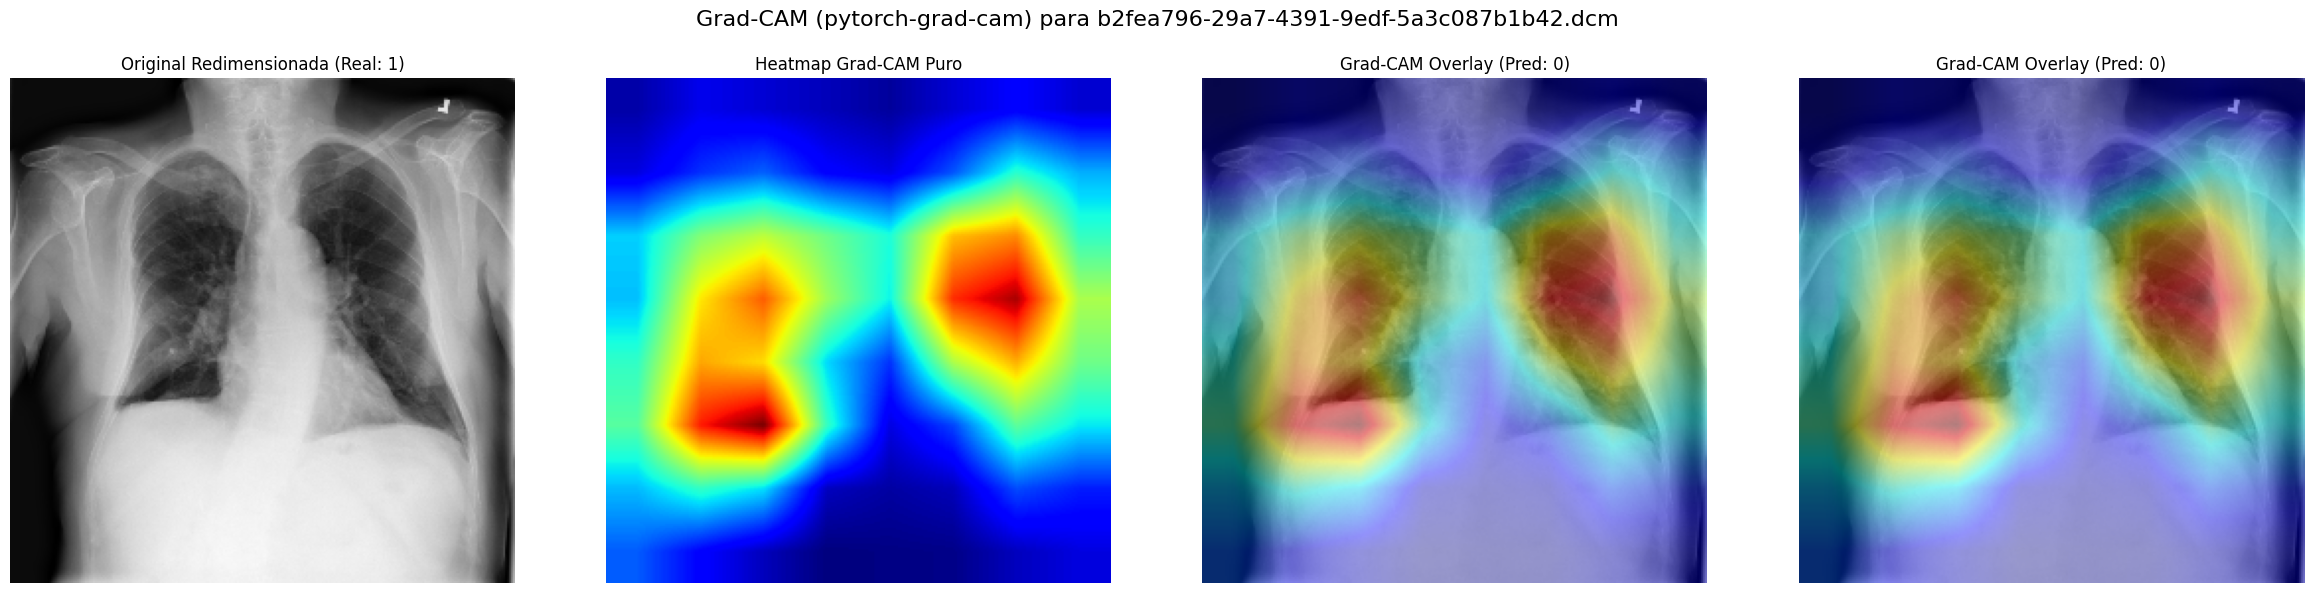

In [ ]:
"""
- GERAÇÃO E VISUALIZAÇÃO DE GRAD-CAM
"""

def generate_grad_cam_with_library(model,
                                   input_tensor_for_model,
                                   original_image_np_0_1_rgb_resized,
                                   target_layers_list,
                                   use_positive_class_target: bool):
    # Gera o heatmap Grad-CAM usando a biblioteca pytorch-grad-cam.
    targets_for_cam = [BinaryClassifierOutputTarget(use_positive_class_target)]

    visualization_result = None
    grayscale_cam_image_for_plot = None

    try:
        with GradCAM(model=model, target_layers=target_layers_list) as cam:
            grayscale_cam_array = cam(input_tensor=input_tensor_for_model, targets=targets_for_cam)

            if grayscale_cam_array is not None and grayscale_cam_array.ndim > 0 and grayscale_cam_array.shape[0] == 1:
                grayscale_cam_image_for_plot = grayscale_cam_array[0, :]
                visualization_result = show_cam_on_image(original_image_np_0_1_rgb_resized,
                                                         grayscale_cam_image_for_plot,
                                                         use_rgb=True,
                                                         image_weight=0.6)
            elif grayscale_cam_array is not None:
                print(f"Warning: grayscale_cam_array shape inesperada: {grayscale_cam_array.shape}.")
                if isinstance(grayscale_cam_array, (list, np.ndarray)) and len(grayscale_cam_array) > 0:
                    grayscale_cam_image_for_plot = grayscale_cam_array[0]
                    if grayscale_cam_image_for_plot.ndim == 3 and grayscale_cam_image_for_plot.shape[0] ==1:
                        grayscale_cam_image_for_plot = grayscale_cam_image_for_plot.squeeze(0)

                    if grayscale_cam_image_for_plot.ndim == 2:
                        visualization_result = show_cam_on_image(original_image_np_0_1_rgb_resized,
                                                                 grayscale_cam_image_for_plot,
                                                                 use_rgb=True,
                                                                 image_weight=0.6)
                    else:
                        print(f"  Forma do heatmap processado não é 2D: {grayscale_cam_image_for_plot.shape}")
            else:
                print("Erro: cam() retornou None para grayscale_cam_array.")

    except AttributeError as ae:
        print(f"AttributeError dentro do GradCAM (provavelmente gradientes são None): {ae}")
        print("Verifique a 'target_layers_list' e a definição dos targets. Para ResNet, tente [model.base_model.layer4[-1].conv3].")
        print("Se o modelo base estiver totalmente congelado (UNFREEZE_COUNT=0), os gradientes podem não fluir para camadas convolucionais da base.")
    except Exception as e_cam:
        print(f"Uma exceção ocorreu ao gerar o Grad-CAM com a biblioteca: {e_cam}")
        import traceback
        traceback.print_exc()

    return visualization_result, grayscale_cam_image_for_plot

# Bloco Principal da Célula Grad-CAM
variables_exist = True
required_vars = ['best_overall_model_path', 'ResNet50BinaryClassifier',
                 'test_df_final', 'data_transforms', 'IMG_SIZE', 'device', 'UNFREEZE_COUNT']
for var_name in required_vars:
    if var_name not in locals() and var_name not in globals():
        print(f"Erro: Variável essencial '{var_name}' não está definida. Execute as células anteriores.")
        variables_exist = False

if variables_exist and (not best_overall_model_path):
    print("Caminho do melhor modelo ('best_overall_model_path') está vazio. Execute o treinamento K-Fold primeiro.")
    variables_exist = False
if variables_exist and ('test_df_final' in locals() and test_df_final.empty):
    print("DataFrame 'test_df_final' está vazio.")
    variables_exist = False

if variables_exist:
    print(f"Carregando o melhor modelo de: {best_overall_model_path}")

    loaded_model_unfreeze_count = UNFREEZE_COUNT
    if "unfreeze0" in best_overall_model_path or "base_frozen" in best_overall_model_path:
        loaded_model_unfreeze_count = 0
    elif "unfreeze5" in best_overall_model_path:
        loaded_model_unfreeze_count = 5
    elif "unfreeze10" in best_overall_model_path:
        loaded_model_unfreeze_count = 10
    else:
        print(f"Não foi possível determinar UNFREEZE_COUNT de {best_overall_model_path}. Assumindo {UNFREEZE_COUNT} (da última execução de treino).")

    grad_cam_model = ResNet50BinaryClassifier(unfreeze_layers=loaded_model_unfreeze_count).to(device)

    try:
        grad_cam_model.load_state_dict(torch.load(best_overall_model_path, map_location=device))
        grad_cam_model.eval()
        print(f"Modelo carregado para Grad-CAM (com {loaded_model_unfreeze_count} camadas descongeladas).")

        if loaded_model_unfreeze_count == 0:
            print("\nALERTA: O modelo carregado parece ter a base ResNet50 totalmente congelada.")
            print("O Grad-CAM em camadas convolucionais congeladas pode não produzir gradientes significativos.")
            print("Para Grad-CAM em camadas da base, idealmente essas camadas deveriam ter requires_grad=True.\n")

        sample_idx = np.random.randint(0, len(test_df_final))
        sample_data = test_df_final.iloc[sample_idx]

        image_path = sample_data['image_path']
        true_label = sample_data['Target']
        detailed_class_true = sample_data['detailed_class']
        true_boxes_original_coords = sample_data['boxes']

        print(f"\nGerando Grad-CAM para: {os.path.basename(image_path)}")
        print(f"Target Real: {true_label} ({detailed_class_true})")
        if true_label == 1 and true_boxes_original_coords and isinstance(true_boxes_original_coords, list) and len(true_boxes_original_coords) > 0:
            print(f"Bounding Boxes Originais: {true_boxes_original_coords}")

        dcm_original = pydicom.dcmread(image_path)
        img_orig_np_dicom = dcm_original.pixel_array
        original_dicom_h, original_dicom_w = img_orig_np_dicom.shape[0], img_orig_np_dicom.shape[1]

        img_orig_np_float = img_orig_np_dicom.astype(np.float32)
        min_val, max_val = img_orig_np_float.min(), img_orig_np_float.max()
        img_orig_np_0_1 = (img_orig_np_float - min_val) / (max_val - min_val) if max_val - min_val > 0 else np.zeros_like(img_orig_np_float)

        if img_orig_np_0_1.ndim == 2:
            img_for_cam_visualization = np.stack([img_orig_np_0_1] * 3, axis=-1)
        elif img_orig_np_0_1.ndim == 3 and img_orig_np_0_1.shape[-1] == 1:
            img_for_cam_visualization = np.concatenate([img_orig_np_0_1] * 3, axis=-1)
        else:
            img_for_cam_visualization = img_orig_np_0_1
        img_for_cam_visualization_resized = cv2.resize(img_for_cam_visualization, (IMG_SIZE, IMG_SIZE))

        img_uint8_for_pil = (img_orig_np_0_1 * 255).astype(np.uint8)
        img_for_model_pil = Image.fromarray(img_uint8_for_pil).convert('RGB')
        input_tensor_vis = data_transforms['val'](img_for_model_pil).unsqueeze(0).to(device)

        try:
            target_layers_for_grad_cam_lib = [grad_cam_model.base_model.layer4[-1].conv3]
            _ = grad_cam_model.base_model.layer4[-1].conv3
        except AttributeError:
            print("Não foi possível acessar model.base_model.layer4[-1].conv3. Tentando model.base_model.layer4[-1].")
            try:
                target_layers_for_grad_cam_lib = [grad_cam_model.base_model.layer4[-1]]
                _ = grad_cam_model.base_model.layer4[-1]
            except AttributeError:
                print("Não foi possível acessar model.base_model.layer4[-1]. Tentando model.base_model.layer4.")
                target_layers_for_grad_cam_lib = [grad_cam_model.base_model.layer4]

        print(f"Camadas alvo Grad-CAM: {[layer.__class__.__name__ for layer in target_layers_for_grad_cam_lib]}")

        with torch.no_grad():
            output_logits = grad_cam_model(input_tensor_vis)
            output_probs = torch.sigmoid(output_logits)
            predicted_class_val = (output_probs > 0.5).item()
            predicted_prob_val = output_probs.item()
        print(f"Modelo predisse: Classe {int(predicted_class_val)}, Prob (classe 1): {predicted_prob_val:.4f}")

        target_positive_class_for_cam = bool(predicted_class_val == 1)

        visualization, grayscale_heatmap_plot = generate_grad_cam_with_library(
            grad_cam_model, input_tensor_vis, img_for_cam_visualization_resized,
            target_layers_for_grad_cam_lib, target_positive_class_for_cam
        )

        if visualization is not None:
            fig, axs = plt.subplots(1, 4, figsize=(24, 6))

            axs[0].imshow(img_for_cam_visualization_resized)
            axs[0].set_title(f"Original Redimensionada (Real: {true_label})")
            axs[0].axis('off')

            if grayscale_heatmap_plot is not None:
                axs[1].imshow(grayscale_heatmap_plot, cmap='jet')
                axs[1].set_title("Heatmap Grad-CAM Puro")
            else:
                axs[1].set_title("Heatmap Puro N/A")
            axs[1].axis('off')

            axs[2].imshow(visualization)
            axs[2].set_title(f"Grad-CAM Overlay (Pred: {int(predicted_class_val)})")
            axs[2].axis('off')

            img_overlay_with_boxes = visualization.copy()
            title_bbox = f"Grad-CAM Overlay (Pred: {int(predicted_class_val)})"
            if true_label == 1 and true_boxes_original_coords and isinstance(true_boxes_original_coords, list) and len(true_boxes_original_coords) > 0:
                scale_x = IMG_SIZE / original_dicom_w
                scale_y = IMG_SIZE / original_dicom_h

                pil_img_overlay_with_boxes = Image.fromarray(img_overlay_with_boxes)
                draw = ImageDraw.Draw(pil_img_overlay_with_boxes)
                for box in true_boxes_original_coords:
                    if not (isinstance(box, list) and len(box) == 4 and all(isinstance(coord, (int, float)) for coord in box)):
                        continue
                    x_min, y_min, x_max, y_max = box

                    x1_scaled = int(x_min * scale_x)
                    y1_scaled = int(y_min * scale_y)
                    x2_scaled = int(x_max * scale_x)
                    y2_scaled = int(y_max * scale_y)

                    draw.rectangle([(x1_scaled, y1_scaled), (x2_scaled, y2_scaled)], outline="lime", width=2)
                img_overlay_with_boxes = np.array(pil_img_overlay_with_boxes)
                title_bbox = "Grad-CAM + BBoxes Reais"

            axs[3].imshow(img_overlay_with_boxes)
            axs[3].set_title(title_bbox)
            axs[3].axis('off')

            plt.suptitle(f"Grad-CAM (pytorch-grad-cam) para {os.path.basename(image_path)}", fontsize=16)
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
        else:
            print("Não foi possível gerar a imagem Grad-CAM com a biblioteca (visualization é None).")

    except FileNotFoundError:
        print(f"Arquivo do modelo não encontrado: {best_overall_model_path}.")
    except Exception as e:
        print(f"Ocorreu um erro geral na célula Grad-CAM: {e}")
        import traceback
        traceback.print_exc()